# Severity prediction of traffic accident in the City of Seattle 

This project aimed at predicting collision severity based on a dataset hosted by the City of Seattle. In particular, the collisions with only property damage are labeled as less severe accidents; the ones involving injuries are deemed as severe. The dataset consists of features such as environmental conditions (<em>e.g.</em>, weather, road condition, and lighting condition), time of the accident, location information (<em>e.g.</em>, type of road), as well as the number of people and vehicles involved. Some of these factors, such as the number of cyclists in the recorded accidents, tend to be obvious features in predicting the severity of the collision, whereas some may be inevident (<em>e.g.</em>, particular road region) but bearing important insights into mitigating the severity of traffic accidents for the city.  

---
## Data
* Categorical features

## Model

## Highlights
* what lead to severe collision

### Load libraries

In [163]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, r2_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc

from xgboost import XGBClassifier
import xgboost as xgb

from catboost import CatBoostClassifier, Pool
import shap

import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [352]:
pd.set_option('display.max_columns', None)

### Read and explore the dataset

In [441]:
df = pd.read_csv('Data-Collisions.csv', low_memory=False, parse_dates=["INCDATE"])
df["MONTH"] = df["INCDATE"].dt.month
df["YEAR"] = df["INCDATE"].dt.year

print(df.shape)
df.head()

(194673, 40)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,MONTH,YEAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013-03-27 00:00:00+00:00,3/27/2013 2:54:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N,3,2013
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006-12-20 00:00:00+00:00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N,12,2006
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004-11-18 00:00:00+00:00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N,11,2004
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013-03-29 00:00:00+00:00,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N,3,2013
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004-01-28 00:00:00+00:00,1/28/2004 8:04:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N,1,2004


In [4]:
df.columns
# Not sure what 'STATUS' is...

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR', 'MONTH', 'YEAR'],
      dtype='object')

1    70.109877
2    29.890123
Name: SEVERITYCODE, dtype: float64


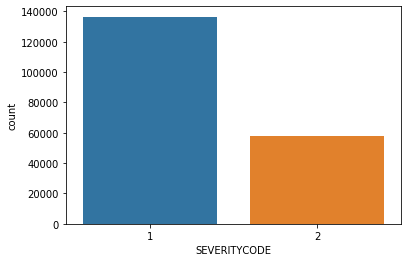

In [5]:
sns.countplot(df["SEVERITYCODE"])

print(df["SEVERITYCODE"].value_counts(normalize=True)*100)

In [353]:
# data type and cardinality for each feature
col_names = []
col_cardinality = []

for feature in df.columns:
    col_names.append(feature)
    cardinality = len(df[feature].unique())
    col_cardinality.append(cardinality)

pd.DataFrame([col_cardinality], columns=col_names)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,MONTH,YEAR,TIMEOFDAY
0,2,23564,23840,194673,194673,194673,194670,2,4,7615,24103,3,2,2,2,11,47,7,3,13,5985,162058,8,39,39,2,2,12,10,10,2,114933,2,64,63,1955,2198,2,12,17,316


In [435]:
df['EXCEPTRSNDESC'].unique()

array([nan,
       'Not Enough Information, or Insufficient Location Information'],
      dtype=object)

### Summary of features
#### Location related information
X, Y(~24000): continous; 

INTKEY(7615); LOCATION(24103); SEGLANEKEY(1955); CROSSWALKKEY(2198)

ADDRTYPE(4); JUNCTIONTYPE(8)

#### Time of the collision
INCDATE[month, year], INCDTTM

#### Descriptive type of the collision
COLLISIONTYPE(11), PERSONCOUNT, PEDCOUNT, PEDCYLCOUNT, VEHCOUNT, 

SDOT_COLCODE(39); SDOT_COLDESC [code given to the collision by SDOT]; ST_COLCODE(64); ST_COLDESC [State Collision Code];

HITPARKEDCAR(2)

#### Possible reasons for collison
INATTENTIONIND(2); UNDERINFL(2); SPEEDING(2); 

PEDROWNOTGRNT(2) [Whether or not the pedestrian right of way was not granted]

#### Other related conditions of the collision
WEATHER(12); ROADCOND(10); LIGHTCOND(10)

#### unknown...
STATUS (matched, unmatched)

### Distribution of severity among cardinality for each feature

In [442]:
feature = 'WEATHER'
df[[feature, "SEVERITYCODE"]].groupby([feature, "SEVERITYCODE"]).size()

# df.groupby(by=feature).size()  #if only interested in how feature is distributed

WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         1                  41
                          2                  15
Clear                     1               75295
                          2               35840
Fog/Smog/Smoke            1                 382
                          2                 187
Other                     1                 716
                          2                 116
Overcast                  1               18969
                          2                8745
Partly Cloudy             1                   2
                          2                   3
Raining                   1               21969
                          2               11176
Severe Crosswind          1                  18
                          2                   7
Sleet/Hail/Freezing Rain  1                  85
                          2                  28
Snowing                   1                 736
                          2                 171
U

In [53]:
df['COLLISIONTYPE'].unique()

array(['Angles', 'Sideswipe', 'Parked Car', 'Other', 'Cycles',
       'Rear Ended', 'Head On', nan, 'Left Turn', 'Pedestrian',
       'Right Turn'], dtype=object)

In [17]:
df['PEDROWNOTGRNT'].describe()

count     4667
unique       1
top          Y
freq      4667
Name: PEDROWNOTGRNT, dtype: object

#### Locations

(-122.42793902636339, -122.22508217363658, 47.4762120096358, 47.7539189403642)

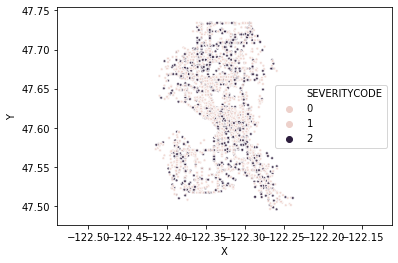

In [443]:
# plot the X/Y coordinates as a scatterplot where each dot is color-coded by the severity code.
# we randomly sample N (e.g. N=5000) to prevent from cluttering.
# X/Y values are clamped so that they are not affected by outliers

indices = np.arange(df.shape[0])
np.random.shuffle(indices)

g = sns.scatterplot(data=df.loc[indices[:5000], :], x='X', y='Y', hue='SEVERITYCODE', alpha=.8, s=8)

# df['Y'].quantile([.05, .95])  # the range of X,Y coordinates for location
g.set(xlim=df['X'].quantile([.05, .95]), ylim=df['Y'].quantile([.05, .95]))
plt.axis('equal')

In [444]:
# we can also plot the likelihood of severity on one axis at a time, at a coarser granularity

def binify_values(s, clamp_alpha=.05, bins=50):
    low, hi = s.quantile([clamp_alpha, 1.0 - clamp_alpha])
    s[s < low] = low
    s[s > hi] = hi
    
    return pd.cut(s, bins, labels=np.arange(bins))

In [447]:
def compute_severity_ratio(g):
    severity_counts = g.groupby('SEVERITYCODE').size()
    ratio = severity_counts.iloc[1] / severity_counts.iloc[0]
    return ratio


def severity_location_distribution(df, loc, nbin):
    # dataframe with binned loc and severity within that range
    df_loc = pd.DataFrame({loc: binify_values(df[loc], bins=nbin), 'SEVERITYCODE': df['SEVERITYCODE']})
    
    # count each severity level
    loc_by_severity_counts = df_loc.groupby([loc, 'SEVERITYCODE']).size().reset_index().rename(columns={0: 'count'})
    
    # visualize
#     sns.barplot(data=loc_by_severity_counts, x=loc, y='count', hue='SEVERITYCODE')
    df_loc.groupby(loc).apply(compute_severity_ratio).plot()



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


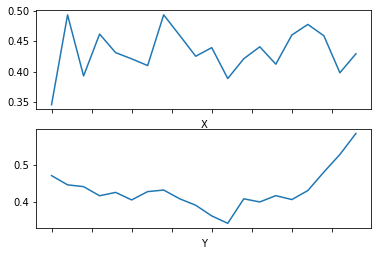

In [448]:
plt.subplot(2, 1, 1)
severity_location_distribution(df, 'X', nbin=20)

plt.subplot(2, 1, 2)
severity_location_distribution(df, 'Y', nbin=20)


#### Time of the day
For example, distribution of collision severity by month & time of the day

In [233]:
df['INCDTTM'] #'INCDTTM', 'INCDATE'

0           3/27/2013 2:54:00 PM
1          12/20/2006 6:55:00 PM
2         11/18/2004 10:20:00 AM
3           3/29/2013 9:26:00 AM
4           1/28/2004 8:04:00 AM
                   ...          
194668     11/12/2018 8:12:00 AM
194669     12/18/2018 9:14:00 AM
194670      1/19/2019 9:25:00 AM
194671      1/15/2019 4:48:00 PM
194672     11/30/2018 3:45:00 PM
Name: INCDTTM, Length: 194673, dtype: object

In [53]:
np.sum(df['MONTH'].isnull())

0

In [286]:
df[['MONTH', "SEVERITYCODE"]].groupby(['MONTH', "SEVERITYCODE"]).size()

MONTH  SEVERITYCODE
1      1               11704
       2                4703
2      1               10293
       2                4097
3      1               11415
       2                4735
4      1               11216
       2                4762
5      1               11567
       2                5196
6      1               11638
       2                4928
7      1               11227
       2                5137
8      1               11214
       2                5082
9      1               11053
       2                4811
10     1               12273
       2                5495
11     1               11683
       2                4899
12     1               11202
       2                4343
dtype: int64

In [165]:
df['INCDATE'].describe()

count                        194673
unique                         5985
top       2006-11-02 00:00:00+00:00
freq                             96
first     2004-01-01 00:00:00+00:00
last      2020-05-20 00:00:00+00:00
Name: INCDATE, dtype: object

In [325]:
df['INCDTTM'][100]

'9/8/2004'

In [327]:
time_format = '%m/%d/%Y'
incdttm = datetime.datetime.strptime(df['INCDTTM'][100], time_format)
incdttm.hour+incdttm.minute/6

0.0

In [332]:
# df['INCDTTM']
def for_dtime(x):
    for time_format in ['%m/%d/%Y %I:%M:%S %p','%m/%d/%Y']: 
        try: 
            incdttm = datetime.datetime.strptime(x, time_format)
            break
        except ValueError:
            pass
    return incdttm.hour+incdttm.minute/6

df['TIMEOFDAY'] = df["INCDTTM"].apply(for_dtime)

### Data preprocess 

#### Data clean up
(fillna & missing data, combine same meaning labels)
* UNDERINFL

In [166]:
# e.g., UNDERINFL, four categories, however, [0,1] & [N,Y] indicate likewise
def for_UNDERINFL(x):
    if x in ['Y','1']:
        return 1
    elif x in ['N','0']:
        return 0
    else:
        return x
    
df["UNDERINFL"] = df["UNDERINFL"].apply(for_UNDERINFL)

In [167]:
df['UNDERINFL'].fillna(0, inplace=True)

* location X, Y

In [7]:
# location
loc_y = binify_values(df['Y'], bins=50)
loc_y = loc_y.cat.add_categories(-99)  # fill missing data with -99
loc_y.fillna(-99, inplace=True)
loc_x = binify_values(df['X'], bins=50)
loc_x = loc_x.cat.add_categories(-99)  # fill missing data with -99
loc_x.fillna(-99, inplace=True)

/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [162]:
df['Y'].describe()

count    194673.000000
mean         47.619543
std           0.055382
min          47.495573
25%          47.578153
50%          47.616802
75%          47.662569
max          47.734142
Name: Y, dtype: float64

In [168]:
# For columns X, Y, remove outliers or nan

# def for_X_Y(s):
#     low, hi = s.quantile([.05, .95])
#     s[s < low] = low
#     s[s > hi] = hi
#     return s
    
# df['X'] = df['X'].apply(for_X_Y)

# missing data: use a special value to fill in missing value (instead of mean), 
# so the tree model can treat these missing values differently
# df['X'].fillna(df['X'].mean(), inplace=True)
# df['Y'].fillna(df['Y'].mean(), inplace=True)
df['X'].fillna(0, inplace=True)
df['Y'].fillna(0, inplace=True)

In [401]:
df['INTKEY'].fillna(0, inplace=True)
df['INTKEY'] = df['INTKEY'].astype(int)

0         37475
1             0
2             0
3             0
4         34387
          ...  
194668        0
194669        0
194670    24760
194671    24349
194672        0
Name: INTKEY, Length: 194673, dtype: int64

#### Ordinal encoding of categorical features

In [169]:
def categ_to_ordinal(df, feature='COLLISIONTYPE'):
    enc = preprocessing.OrdinalEncoder(dtype=np.int)
    col = df[feature].fillna('').values.reshape(-1, 1)
    ordinal_encoded = enc.fit_transform(col)

    return pd.Series(ordinal_encoded.reshape(-1), name=feature)

In [190]:
categ_to_ordinal(df)

0          1
1         10
2          6
3          5
4          1
          ..
194668     3
194669     8
194670     4
194671     2
194672     8
Name: COLLISIONTYPE, Length: 194673, dtype: int64

#### One hot encoding of categorical features

In [170]:
def categ_to_one_hot(df, feature='ROADCOND'):
    enc = preprocessing.OneHotEncoder()
    # fill in None, to reshape to 2D (column)
    col = df[feature].fillna("").values.reshape(-1, 1)
    # one hot encode
    one_hot_encoded = enc.fit_transform(col).toarray()
    
    # to a data frame
    df_cols = {}
    for col_index, cat in enumerate(enc.categories_[0]):
        df_cols[feature + '_' + cat] = one_hot_encoded[:, col_index]

    return pd.DataFrame(df_cols)

In [171]:
df_addrtype = categ_to_one_hot(df, feature='ADDRTYPE')
df_collisiontype = categ_to_one_hot(df, feature='COLLISIONTYPE')
df_junctiontype = categ_to_one_hot(df, feature='JUNCTIONTYPE')

df_weather = categ_to_one_hot(df, feature='WEATHER')
df_roadcond = categ_to_one_hot(df, feature='ROADCOND')
df_lightcond = categ_to_one_hot(df, feature='LIGHTCOND')

In [71]:
df['WEATHER'].unique()

array(['Overcast', 'Raining', 'Clear', nan, 'Unknown', 'Other', 'Snowing',
       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
       'Severe Crosswind', 'Partly Cloudy'], dtype=object)

In [172]:
df_sdotcold=categ_to_one_hot(df, feature='SDOT_COLDESC')

### Decision tree model

In [336]:
df_preprocessed = pd.concat([df_addrtype, df_collisiontype, df_junctiontype, 
                             df_weather, df_roadcond, df_lightcond, 
                             df_sdotcold,
                             df[['PERSONCOUNT', 'PEDCYLCOUNT', 'PEDCOUNT', 'VEHCOUNT', 'UNDERINFL', 
                                 'X', 'Y', 'TIMEOFDAY', 'MONTH', 'YEAR']] 
                             ], axis=1) # loc_y.astype(int), loc_x.astype(int)
# df_preprocessed = pd.concat([df['PEDCOUNT'], df['PEDCYLCOUNT'], df['VEHCOUNT'], df_sdotcold], axis=1)
# df_preprocessed = pd.concat([df_collisiontype, df['UNDERINFL']], axis=1)
df_preprocessed

,ADDRTYPE_,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection,COLLISIONTYPE_,COLLISIONTYPE_Angles,COLLISIONTYPE_Cycles,COLLISIONTYPE_Head On,COLLISIONTYPE_Left Turn,COLLISIONTYPE_Other,...,PERSONCOUNT,PEDCYLCOUNT,PEDCOUNT,VEHCOUNT,UNDERINFL,X,Y,TIMEOFDAY,MONTH,YEAR
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2,0,0,2,0.0,-122.323148,47.703140,23.000000,3,2013
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0,0,2,0.0,-122.347294,47.647172,27.166667,12,2006
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,0,0,3,0.0,-122.334540,47.607871,13.333333,11,2004
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3,0,0,3,0.0,-122.334803,47.604803,13.333333,3,2013
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2,0,0,2,0.0,-122.306426,47.545739,8.666667,1,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3,0,0,2,0.0,-122.290826,47.565408,10.000000,11,2018
194669,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0,0,2,0.0,-122.344526,47.690924,11.333333,12,2018
194670,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3,0,0,2,0.0,-122.306689,47.683047,13.166667,1,2019
194671,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2,1,0,1,0.0,-122.355317,47.678734,24.000000,1,2019


In [337]:
X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed, df['SEVERITYCODE'], test_size=0.2, random_state=1)
tree = DecisionTreeClassifier(criterion="gini", max_depth = 10, class_weight=None).fit(X_train, y_train)
# class_weight:default-None; 'balanced' means to adjust weights based on label distribution 
#             (inverse to the proportion, so more leads to less important)
# max_features: if None, all features are considered 

tree_pred = tree.predict(X_test)
tree_pred

print('Score:',accuracy_score(tree_pred, y_test))
print('F1-Score:',f1_score(tree_pred, y_test))
print('Confusion Martix:')
print(confusion_matrix(y_test, tree_pred))
print('')
print('Classification Report:')
print(classification_report(y_test, tree_pred))

Score: 0.7580326184666752
F1-Score: 0.8472872866382454
Confusion Martix:
[[26135  1224]
 [ 8197  3379]]

Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.96      0.85     27359
           2       0.73      0.29      0.42     11576

    accuracy                           0.76     38935
   macro avg       0.75      0.62      0.63     38935
weighted avg       0.75      0.76      0.72     38935



0.7903237973462629


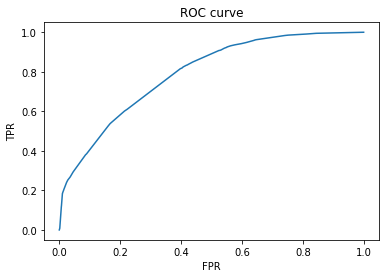

In [338]:
predictions = tree.predict_proba(X_test)
print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test-1, predictions[:,1])
# fpr_0, tpr_0, _ = roc_curve((3-y_test)-1, predictions[:,0])

plt.clf()
plt.plot(fpr, tpr)
# plt.plot(fpr_0, tpr_0)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

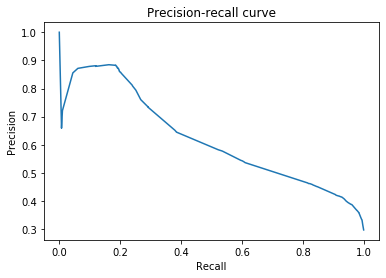

pr auc:0.6218940936050235


In [339]:
# since the data is also imbalance (more non-severe than yes), look at Precision-Recall curve as well
precision, recall, _ = precision_recall_curve(y_test-1, predictions[:,1])
plt.clf()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.show()

print('pr auc:' + str(auc(recall, precision)))

Text(0, 0.5, 'Feature Importance Score')

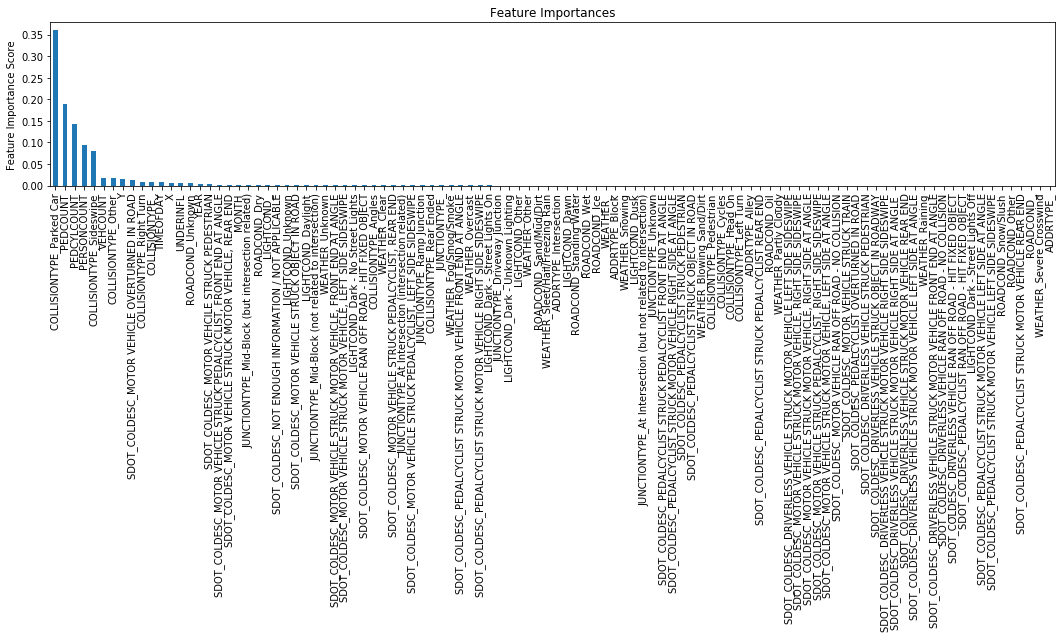

In [340]:
pd.Series(tree.feature_importances_, index=df_preprocessed.columns)
# the importance decided based on the information gain achieved based on the feature at splits
#
plt.figure(figsize=[18,3])
feat_imp = pd.Series(tree.feature_importances_, index=df_preprocessed.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [91]:
tree.tree_.max_depth

15

#### Parameter tuning
cross-validated grid-search over a parameter grid

In [341]:
decision_tree_model = DecisionTreeClassifier(random_state=0)
# cross_val_score(clf, df_preprocessed, df['SEVERITYCODE'], cv=10)
#
## df_collisiontype by itself can push the cross_val_score to ~.75;
## df['PEDCYLCOUNT'] can do ~.72; df['PEDCOUNT'] is ~.73; df['VEHCOUNT'] is ~.71; these three combined reaches .75;
#
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[5, 10, 15]}
clf = GridSearchCV(decision_tree_model, parameters, scoring={'roc': 'roc_auc', 'f1': 'f1'}, refit='roc')
# cv: default None, which is 5-fold
# return_train_score: if True, besides test score, also return train score. default is False

clf.fit(X_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [5, 10, 15]},
             

In [129]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_f1',
 'mean_test_roc',
 'param_criterion',
 'param_max_depth',
 'params',
 'rank_test_f1',
 'rank_test_roc',
 'split0_test_f1',
 'split0_test_roc',
 'split1_test_f1',
 'split1_test_roc',
 'split2_test_f1',
 'split2_test_roc',
 'split3_test_f1',
 'split3_test_roc',
 'split4_test_f1',
 'split4_test_roc',
 'std_fit_time',
 'std_score_time',
 'std_test_f1',
 'std_test_roc']

In [342]:
clf.cv_results_['mean_test_roc']

array([0.77203914, 0.79057567, 0.77155959, 0.77234216, 0.79041011,
       0.77160324])

In [343]:
# clf.best_estimator_
# clf.best_score_
clf.best_params_

{'criterion': 'gini', 'max_depth': 10}

### Random forest

In [345]:
forest = RandomForestClassifier(n_estimators=100,criterion="gini", max_depth = 15, 
                                class_weight=None).fit(X_train, y_train)
# max_features: default - 'auto', sqrt(n_features)
# bootstrap: bool, default=True
# max_samples: int or float, default=None (when bootstrap is TRUE, None - draw same number of samples)
#
forest_pred = forest.predict(X_test)
forest_pred

print('Score:',accuracy_score(forest_pred, y_test))
print('F1-Score:',f1_score(forest_pred, y_test))
print('Confusion Martix:')
print(confusion_matrix(y_test, forest_pred))
print('')
print('Classification Report:')
print(classification_report(y_test, forest_pred))

predictions = forest.predict_proba(X_test)
print('auc: ' + str(roc_auc_score(y_test, predictions[:,1])))

precision, recall, _ = precision_recall_curve(y_test-1, predictions[:,1])
print('pr auc: ' + str(auc(recall, precision)))

Score: 0.7610376268139206
F1-Score: 0.8508161498252252
Confusion Martix:
[[26531   828]
 [ 8476  3100]]

Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.97      0.85     27359
           2       0.79      0.27      0.40     11576

    accuracy                           0.76     38935
   macro avg       0.77      0.62      0.63     38935
weighted avg       0.77      0.76      0.72     38935

auc: 0.8009246166807191
pr auc: 0.6406906382689743


In [61]:
pd.Series(forest.feature_importances_, index=df_preprocessed.columns)

ADDRTYPE_                0.000373
ADDRTYPE_Alley           0.000144
ADDRTYPE_Block           0.030700
ADDRTYPE_Intersection    0.033054
COLLISIONTYPE_           0.000409
                           ...   
PEDCOUNT                 0.089248
VEHCOUNT                 0.034384
UNDERINFL                0.001437
Y                        0.001276
X                        0.001429
Length: 101, dtype: float64

In [62]:
forest.n_features_

101

#### Parameter tuning 

In [149]:
forest_model = RandomForestClassifier(random_state=0)

parameters = {'n_estimators':[50, 100, 150], 'max_depth':[3, 6, 9, 12]}
clf = GridSearchCV(forest_model, parameters, scoring={'roc': 'roc_auc', 'f1': 'f1'}, refit='roc')
# cv: default None, which is 5-fold
# return_train_score: if True, besides test score, also return train score. default is False

clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                

In [150]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.cv_results_['params'])
clf.cv_results_['mean_test_roc']

{'max_depth': 12, 'n_estimators': 150}
0.7994482300331068
[{'max_depth': 3, 'n_estimators': 50}, {'max_depth': 3, 'n_estimators': 100}, {'max_depth': 3, 'n_estimators': 150}, {'max_depth': 6, 'n_estimators': 50}, {'max_depth': 6, 'n_estimators': 100}, {'max_depth': 6, 'n_estimators': 150}, {'max_depth': 9, 'n_estimators': 50}, {'max_depth': 9, 'n_estimators': 100}, {'max_depth': 9, 'n_estimators': 150}, {'max_depth': 12, 'n_estimators': 50}, {'max_depth': 12, 'n_estimators': 100}, {'max_depth': 12, 'n_estimators': 150}]


array([0.76480333, 0.76791014, 0.770238  , 0.78727624, 0.78867528,
       0.78857367, 0.79459342, 0.79533269, 0.79521104, 0.79889862,
       0.79933072, 0.79944823])

### xgboost

In [229]:
dtrain = xgb.DMatrix(X_train, label=y_train-1)
dtest = xgb.DMatrix(X_test, label=y_test-1)

param = {'max_depth': 5, 'eta': .1, 'objective': 'binary:logistic', 'min_child_weight': 1}
param['nthread'] = 4
param['eval_metric'] = 'auc'  # if multiple, the last one would be used for early stopping evaluation

evallist = [(dtrain, 'train'), (dtest, 'eval')]  # to be able to see both train/val errors, however, eval_auc would be used for early stopping

num_round = 50
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=5) 
# if the metric result [eval_auc] do not improve for N rounds, model should stop training

ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)  # use the best model
print('auc: ' + str(roc_auc_score(y_test-1, ypred)))

[0]	train-auc:0.77271	eval-auc:0.77187
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 5 rounds.
[1]	train-auc:0.77280	eval-auc:0.77190
[2]	train-auc:0.77287	eval-auc:0.77208
[3]	train-auc:0.77289	eval-auc:0.77204
[4]	train-auc:0.77290	eval-auc:0.77208
[5]	train-auc:0.78010	eval-auc:0.77894
[6]	train-auc:0.78042	eval-auc:0.77941
[7]	train-auc:0.78291	eval-auc:0.78196
[8]	train-auc:0.78295	eval-auc:0.78193
[9]	train-auc:0.78302	eval-auc:0.78194
[10]	train-auc:0.78497	eval-auc:0.78371
[11]	train-auc:0.78754	eval-auc:0.78602
[12]	train-auc:0.78991	eval-auc:0.78862
[13]	train-auc:0.79059	eval-auc:0.78902
[14]	train-auc:0.79095	eval-auc:0.78929
[15]	train-auc:0.79217	eval-auc:0.79061
[16]	train-auc:0.79326	eval-auc:0.79119
[17]	train-auc:0.79356	eval-auc:0.79141
[18]	train-auc:0.79384	eval-auc:0.79180
[19]	train-auc:0.79391	eval-auc:0.79182
[20]	train-auc:0.79447	eval-auc:0.79221
[21]	train-auc:0.79470	eval-au

In [204]:
ypred

array([0.24655373, 0.6893549 , 0.00295407, ..., 0.5131798 , 0.33869988,
       0.6005166 ], dtype=float32)

In [73]:
# xgb.plot_importance(bst)

Text(0, 0.5, 'Feature Importance Score')

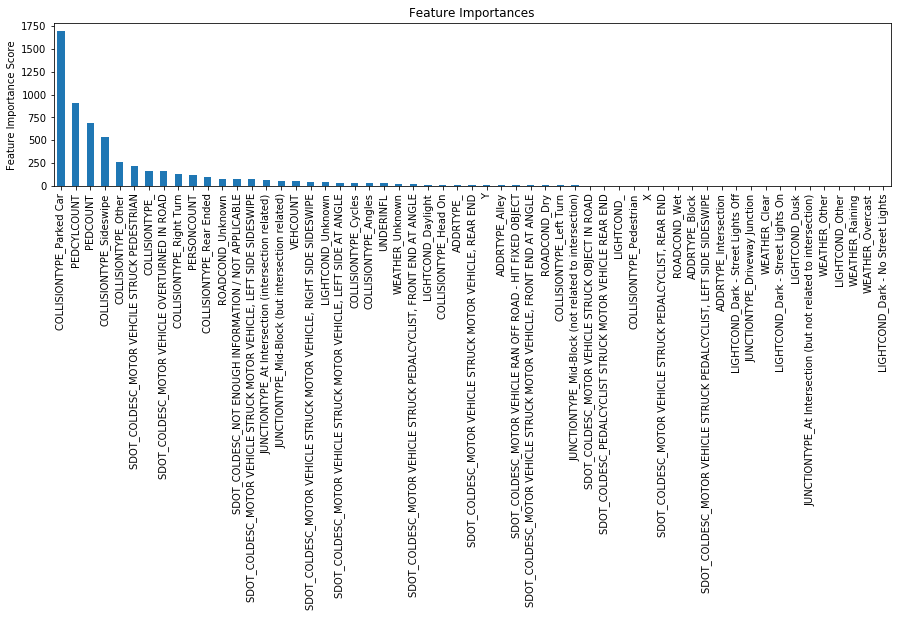

In [230]:
# bst.get_fscore()
bst_importance = bst.get_score(importance_type='gain')
# {k: v for k, v in sorted(bst_importance.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=[15,3])
feat_imp = pd.Series(bst_importance).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [232]:
# xgb.plot_tree(bst, num_trees=2)

In [217]:
# use a different grammar - sklearn wrapper for XGBoost
model = XGBClassifier(importance_type='gain', 
              learning_rate=0.5, max_depth=5,
              min_child_weight=1, 
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["auc"], eval_set=eval_set, early_stopping_rounds=5, verbose=True)

ypred = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)
print('auc: ' + str(roc_auc_score(y_test-1, ypred[:,1])))

[0]	validation_0-auc:0.77187
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.77924
[2]	validation_0-auc:0.78469
[3]	validation_0-auc:0.78992
[4]	validation_0-auc:0.79180
[5]	validation_0-auc:0.79374
[6]	validation_0-auc:0.79654
[7]	validation_0-auc:0.79725
[8]	validation_0-auc:0.79804
[9]	validation_0-auc:0.79985
[10]	validation_0-auc:0.80039
[11]	validation_0-auc:0.80085
[12]	validation_0-auc:0.80119
[13]	validation_0-auc:0.80126
[14]	validation_0-auc:0.80157
[15]	validation_0-auc:0.80182
[16]	validation_0-auc:0.80208
[17]	validation_0-auc:0.80214
[18]	validation_0-auc:0.80208
[19]	validation_0-auc:0.80254
[20]	validation_0-auc:0.80284
[21]	validation_0-auc:0.80284
[22]	validation_0-auc:0.80278
[23]	validation_0-auc:0.80272
[24]	validation_0-auc:0.80271
[25]	validation_0-auc:0.80267
[26]	validation_0-auc:0.80269
Stopping. Best iteration:
[21]	validation_0-auc:0.80284

auc: 0.8028400132407228


#### Hyperparameter Tuning

In [220]:
model = xgb.XGBClassifier()
param_dist = {"max_depth": [5,10],
              "min_child_weight" : [1,5,10],
              "n_estimators": [200],
              "learning_rate": [0.1,1]}
# min_child_weight controls model complexity, similar to # of instance in leaf (though not exact)
#
grid_search = GridSearchCV(model, param_grid=param_dist, cv=3, verbose=10, n_jobs=-1)
eval_set = [(X_test, y_test)]
grid_search.fit(X_train, y_train, eval_set=eval_set, eval_metric=["auc"], early_stopping_rounds=5)

grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  36 | elapsed:  1.8min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  13 out of  36 | elapsed:  2.0min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  17 out of  36 | elapsed:  2.1min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  21 out of  36 | elapsed:  2.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:  2.2min remaining:   58.9s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  2.3min remaining:   33.0s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  2.3min remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.0min finished


[0]	validation_0-auc:0.77187
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.77190
[2]	validation_0-auc:0.77208
[3]	validation_0-auc:0.77204
[4]	validation_0-auc:0.77208
[5]	validation_0-auc:0.77894
[6]	validation_0-auc:0.77941
[7]	validation_0-auc:0.78196
[8]	validation_0-auc:0.78193
[9]	validation_0-auc:0.78194
[10]	validation_0-auc:0.78371
[11]	validation_0-auc:0.78602
[12]	validation_0-auc:0.78862
[13]	validation_0-auc:0.78902
[14]	validation_0-auc:0.78929
[15]	validation_0-auc:0.79061
[16]	validation_0-auc:0.79119
[17]	validation_0-auc:0.79141
[18]	validation_0-auc:0.79180
[19]	validation_0-auc:0.79182
[20]	validation_0-auc:0.79221
[21]	validation_0-auc:0.79235
[22]	validation_0-auc:0.79291
[23]	validation_0-auc:0.79336
[24]	validation_0-auc:0.79355
[25]	validation_0-auc:0.79361
[26]	validation_0-auc:0.79372
[27]	validation_0-auc:0.79449
[28]	validation_0-auc:0.79474
[29]	validation_0-auc:0.79550
[30]	validation_0-auc:0.79580
[31]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [226]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 200}

### catboost

In [132]:
import catboost
print(catboost.__version__)

0.24.2


In [426]:
df['ST_COLCODE'].fillna(999, inplace=True)

In [439]:
df['WEATHER'].unique()
# np.sum(df['ST_COLCODE'].isnull())

array(['Overcast', 'Raining', 'Clear', nan, 'Unknown', 'Other', 'Snowing',
       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
       'Severe Crosswind', 'Partly Cloudy'], dtype=object)

In [273]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR', 'MONTH', 'YEAR'],
      dtype='object')

In [428]:
df_preprocessed = pd.concat([categ_to_ordinal(df, feature='COLLISIONTYPE'), 
                             categ_to_ordinal(df, feature='ADDRTYPE'),
                             categ_to_ordinal(df, feature='JUNCTIONTYPE'),
                             categ_to_ordinal(df, feature='HITPARKEDCAR'),
                             categ_to_ordinal(df, feature='INATTENTIONIND'),
                             categ_to_ordinal(df, feature='UNDERINFL'),
                             categ_to_ordinal(df, feature='SPEEDING'),
                             categ_to_ordinal(df, feature='PEDROWNOTGRNT'), 
                             categ_to_ordinal(df, feature='WEATHER'),
                             categ_to_ordinal(df, feature='ROADCOND'),
                             categ_to_ordinal(df, feature='LIGHTCOND'),
                             df[['SDOT_COLCODE', 'ST_COLCODE', 'INTKEY', 'SEGLANEKEY', 'CROSSWALKKEY',
                                 'X', 'Y', 'MONTH', 'YEAR', 'TIMEOFDAY',
                                 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT']]], axis=1)
#
# not necessary to oridnal_encode categorical featuers (it should accept string values), 
# however need to handle missing data, thus keeping categ_to_ordinal hear.
#
# df_preprocessed = pd.concat([categ_to_ordinal(df, feature='WEATHER'), 
#                              df[['PEDCOUNT','SDOT_COLCODE']]], axis=1)


In [429]:
cat_features = list(range(16))
print(cat_features)
df_preprocessed

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


,COLLISIONTYPE,ADDRTYPE,JUNCTIONTYPE,HITPARKEDCAR,INATTENTIONIND,UNDERINFL,SPEEDING,PEDROWNOTGRNT,WEATHER,ROADCOND,LIGHTCOND,SDOT_COLCODE,ST_COLCODE,INTKEY,SEGLANEKEY,CROSSWALKKEY,X,Y,MONTH,YEAR,TIMEOFDAY,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT
0,1,3,2,0,0,0,0,0,5,9,6,11,10,37475,0,0,-122.323148,47.703140,3,2013,23.000000,2,0,0,2
1,10,2,5,0,0,0,0,0,7,9,3,16,11,0,0,0,-122.347294,47.647172,12,2006,27.166667,2,0,0,2
2,6,2,5,0,0,0,0,0,5,1,6,14,32,0,0,0,-122.334540,47.607871,11,2004,13.333333,4,0,0,3
3,5,2,5,0,0,0,0,0,2,1,6,11,23,0,0,0,-122.334803,47.604803,3,2013,13.333333,3,0,0,3
4,1,3,2,0,0,0,0,0,7,9,6,11,10,34387,0,0,-122.306426,47.545739,1,2004,8.666667,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,3,2,5,0,0,0,0,0,2,1,6,11,24,0,0,0,-122.290826,47.565408,11,2018,10.000000,3,0,0,2
194669,8,2,5,0,1,0,0,0,7,9,6,14,13,0,0,0,-122.344526,47.690924,12,2018,11.333333,2,0,0,2
194670,4,3,2,0,0,0,0,0,2,1,6,11,28,24760,0,0,-122.306689,47.683047,1,2019,13.166667,3,0,0,2
194671,2,3,2,0,0,0,0,0,2,1,7,51,5,24349,4308,0,-122.355317,47.678734,1,2019,24.000000,2,0,1,1


In [430]:
X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed, df['SEVERITYCODE'], test_size=0.2, random_state=1)

train_pool = Pool(data=X_train, 
                  label=y_train,
                  cat_features=cat_features)
val_pool = Pool(data=X_test, 
               label=y_test, 
               cat_features=cat_features)

In [431]:
model = CatBoostClassifier(iterations=500,
                           depth=6,
#                            learning_rate=1e-2, # algo automatically decided
                           loss_function='Logloss', #'CrossEntropy', 'Logloss'
                           eval_metric='AUC', 
                           early_stopping_rounds=50,
                           verbose=True,
                           ignored_features=[])
# train the model
model.fit(train_pool, eval_set=val_pool,
         use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
         plot=True)
# make the prediction using the resulting model
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)

print('auc: ' + str(roc_auc_score(y_test-1, preds_proba[:,1])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.149066
0:	test: 0.7882933	best: 0.7882933 (0)	total: 178ms	remaining: 1m 28s
1:	test: 0.7919157	best: 0.7919157 (1)	total: 293ms	remaining: 1m 12s
2:	test: 0.7945708	best: 0.7945708 (2)	total: 415ms	remaining: 1m 8s
3:	test: 0.7962426	best: 0.7962426 (3)	total: 560ms	remaining: 1m 9s
4:	test: 0.7964887	best: 0.7964887 (4)	total: 701ms	remaining: 1m 9s
5:	test: 0.7982136	best: 0.7982136 (5)	total: 822ms	remaining: 1m 7s
6:	test: 0.8001950	best: 0.8001950 (6)	total: 952ms	remaining: 1m 7s
7:	test: 0.8012025	best: 0.8012025 (7)	total: 1.07s	remaining: 1m 6s
8:	test: 0.8020189	best: 0.8020189 (8)	total: 1.22s	remaining: 1m 6s
9:	test: 0.8024048	best: 0.8024048 (9)	total: 1.43s	remaining: 1m 9s
10:	test: 0.8028359	best: 0.8028359 (10)	total: 1.57s	remaining: 1m 9s
11:	test: 0.8029105	best: 0.8029105 (11)	total: 1.8s	remaining: 1m 13s
12:	test: 0.8031149	best: 0.8031149 (12)	total: 1.99s	remaining: 1m 14s
13:	test: 0.8034943	best: 0.8034943 (13)	total: 2.16s	remaining:

116:	test: 0.8099257	best: 0.8099257 (116)	total: 14.2s	remaining: 46.4s
117:	test: 0.8099340	best: 0.8099340 (117)	total: 14.3s	remaining: 46.3s
118:	test: 0.8099493	best: 0.8099493 (118)	total: 14.5s	remaining: 46.3s
119:	test: 0.8099665	best: 0.8099665 (119)	total: 14.6s	remaining: 46.2s
120:	test: 0.8099380	best: 0.8099665 (119)	total: 14.7s	remaining: 46.1s
121:	test: 0.8099656	best: 0.8099665 (119)	total: 14.8s	remaining: 45.9s
122:	test: 0.8099841	best: 0.8099841 (122)	total: 14.9s	remaining: 45.7s
123:	test: 0.8100401	best: 0.8100401 (123)	total: 15s	remaining: 45.6s
124:	test: 0.8100579	best: 0.8100579 (124)	total: 15.2s	remaining: 45.6s
125:	test: 0.8101163	best: 0.8101163 (125)	total: 15.4s	remaining: 45.8s
126:	test: 0.8101396	best: 0.8101396 (126)	total: 15.6s	remaining: 45.9s
127:	test: 0.8101428	best: 0.8101428 (127)	total: 15.8s	remaining: 45.9s
128:	test: 0.8101869	best: 0.8101869 (128)	total: 16s	remaining: 45.9s
129:	test: 0.8102173	best: 0.8102173 (129)	total: 16.1s

229:	test: 0.8107001	best: 0.8107219 (216)	total: 27.7s	remaining: 32.5s
230:	test: 0.8106883	best: 0.8107219 (216)	total: 27.8s	remaining: 32.4s
231:	test: 0.8106725	best: 0.8107219 (216)	total: 27.9s	remaining: 32.3s
232:	test: 0.8106676	best: 0.8107219 (216)	total: 28.1s	remaining: 32.2s
233:	test: 0.8106701	best: 0.8107219 (216)	total: 28.2s	remaining: 32s
234:	test: 0.8106768	best: 0.8107219 (216)	total: 28.3s	remaining: 31.9s
235:	test: 0.8106731	best: 0.8107219 (216)	total: 28.4s	remaining: 31.7s
236:	test: 0.8106588	best: 0.8107219 (216)	total: 28.5s	remaining: 31.6s
237:	test: 0.8106900	best: 0.8107219 (216)	total: 28.6s	remaining: 31.5s
238:	test: 0.8106929	best: 0.8107219 (216)	total: 28.7s	remaining: 31.3s
239:	test: 0.8106961	best: 0.8107219 (216)	total: 28.8s	remaining: 31.2s
240:	test: 0.8107021	best: 0.8107219 (216)	total: 28.9s	remaining: 31s
241:	test: 0.8107012	best: 0.8107219 (216)	total: 29s	remaining: 30.9s
242:	test: 0.8106879	best: 0.8107219 (216)	total: 29.2s	r

In [406]:
model.tree_count_

213

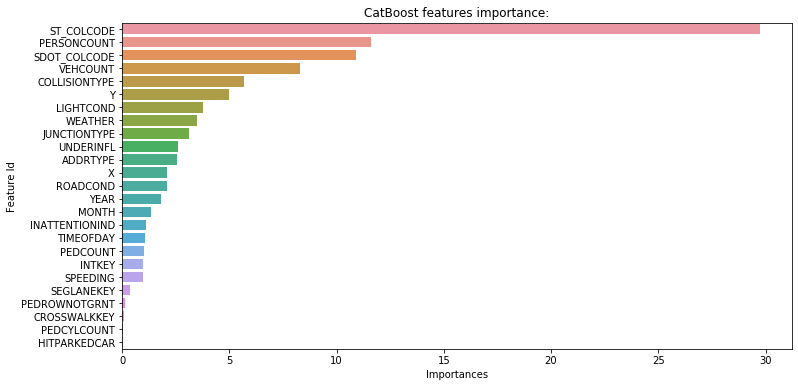

In [432]:
# feature importance
df_catboost_feature_importance = model.get_feature_importance(data=train_pool,
#                                  type='ShapValues', #type='LossFunctionChange',
                                 prettified=True,
                                 thread_count=-1,verbose=False)

plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=df_catboost_feature_importance);
plt.title('CatBoost features importance:');

In [280]:
explainer = shap.TreeExplainer(model) # insert model
shap_values = explainer.shap_values(train_pool) # insert train Pool object

# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


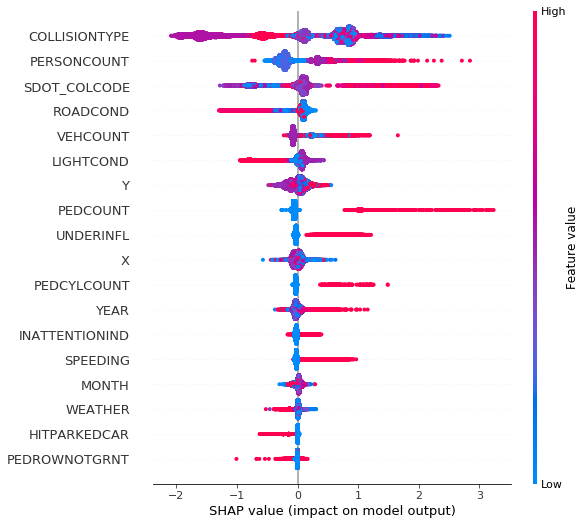

In [281]:
shap.summary_plot(shap_values, X_train)

In [266]:
# feature evaluation?
from catboost.utils import create_cd
feature_names = dict()
for column, name in enumerate(X_train):
    feature_names[column] = name
    
create_cd(
#     label=0, 
    cat_features=cat_features,
    feature_names=feature_names,
    output_path='catboost_train.cd')

!cat catboost_train.cd # column descriptors

0	Categ	COLLISIONTYPE
1	Categ	HITPARKEDCAR
2	Categ	INATTENTIONIND
3	Categ	UNDERINFL
4	Categ	SPEEDING
5	Categ	PEDROWNOTGRNT
6	Categ	WEATHER
7	Categ	ROADCOND
8	Categ	LIGHTCOND
9	Categ	SDOT_COLCODE
10	Num	X
11	Num	Y
12	Num	PERSONCOUNT
13	Num	PEDCOUNT
14	Num	PEDCYLCOUNT
15	Num	VEHCOUNT


In [271]:
# from catboost.eval.catboost_evaluation import *
# learn_params = {'iterations': 20, # 2000
#                 'learning_rate': 0.5, # we set big learning_rate,
#                                       # because we have small
#                                       # #iterations
#                 'random_seed': 0,
#                 'verbose': False,
#                 'loss_function' : 'Logloss',
#                 'boosting_type': 'Plain'}

# df_preprocessed.to_csv('catboost_train.tsv',
#     index=False, sep='\t', header=False
# )

# evaluator = CatboostEvaluation('catboost_train.tsv',
#                                fold_size=10000, # <= 50% of dataset
#                                fold_count=20,
#                                column_description='catboost_train.cd',
#                                partition_random_seed=0,
#                                #working_dir=... 
# )
# result = evaluator.eval_features(learn_config=learn_params,
#                                  eval_metrics=['Logloss', 'Accuracy'],
#                                  features_to_eval=[6, 7, 8])

# from catboost.eval.evaluation_result import *
# logloss_result = result.get_metric_results('Logloss')
# logloss_result.get_baseline_comparison(
#     ScoreConfig(ScoreType.Rel, overfit_iterations_info=False))

In [270]:
from catboost import cv

params = {'iterations':100, 'depth':6, 
          'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 1234
         }
scores = cv(pool=train_pool,
            params=params, 
            fold_count=4,
            shuffle=True,
            stratified=True, # if True the folds are made by preserving the percentage of samples for each class
            plot=True
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7354949	best: 0.7354949 (0)	total: 222ms	remaining: 22s
99:	test: 0.7994598	best: 0.7994598 (99)	total: 13.1s	remaining: 0us
